In [1]:
import os
import pickle
import cv2 as cv
import numpy as np 
from mtcnn import MTCNN
import tensorflow as tf 
from sklearn.svm import SVC
import matplotlib.pyplot as plt 
from keras_facenet import FaceNet
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

2024-10-17 12:37:59.277539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-17 12:37:59.372168: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-17 12:37:59.399361: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-17 12:37:59.599112: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-17 12:38:01.048739: W tensorflow/compiler/tf2

I0000 00:00:1729168683.207489    2066 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-17 12:38:03.515737: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


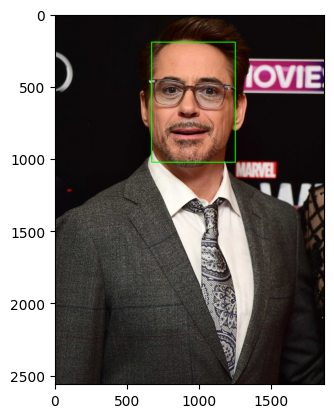

In [2]:
detector = MTCNN()
img = "train_data/robert_downey/3.jpg"
img = cv.imread(img)
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
x,y,w,h = detector.detect_faces(img)[0]['box']
cv.rectangle(img,(x,y),(x+w,y+h),(0,255,0),5)
plt.imshow(img)

In [3]:
class Feature_Extraction:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160, 160)
        self.detector = MTCNN()
        self.X = []
        self.Y = []

    def extract_face(self, file_name):
        img = cv.imread(file_name)
        if img is None:
            print(f"Failed to load image {file_name}. It may be corrupted or not exist.")
            return None
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        faces = self.detector.detect_faces(img)

        if len(faces) == 0:
            print(f"No faces found in {file_name}.")
            return None

        x, y, width, height = faces[0]['box']
        x, y = abs(x), abs(y)
        face = img[y:y + height, x:x + width]
        face_arr = cv.resize(face, self.target_size)
        return face_arr

    def load_faces(self, dir):
        FACE = []
        for im_name in os.listdir(dir):
            try:
                path = os.path.join(dir, im_name)
                single_face = self.extract_face(path)
                if single_face is not None:
                    FACE.append(single_face)
            except Exception as e:
                print("Exception while load_face: {}".format(e))
        return FACE

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = os.path.join(self.directory, sub_dir)
            print(path)
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            self.X.extend(FACES)
            self.Y.extend(labels)
        return np.asarray(self.X), np.asarray(self.Y)
    

    def plot_image(self):
        for num,image in enumerate(self.X):
            ncols = 6
            nrows = (int) (len(self.Y)//ncols)
            if num>= ncols*nrows:
                break
            plt.subplot(nrows,ncols,num+1)
            plt.axis("off")
            plt.imshow(image)


face_loading = Feature_Extraction("train_data")
X,Y = face_loading.load_classes()


train_data/taylor_swift
train_data/robert_downey
No faces found in train_data/robert_downey/10.jfif.
train_data/yasin
No faces found in train_data/yasin/b9f571f4-864a-11ef-9e8e-f48c50632a09.jpg.
No faces found in train_data/yasin/b1afab04-864a-11ef-9e8e-f48c50632a09.jpg.
No faces found in train_data/yasin/b4a48190-864a-11ef-9e8e-f48c50632a09.jpg.
No faces found in train_data/yasin/adf66d04-864a-11ef-9e8e-f48c50632a09.jpg.
No faces found in train_data/yasin/aeabc906-864a-11ef-9e8e-f48c50632a09.jpg.
No faces found in train_data/yasin/be9ae70c-864a-11ef-9e8e-f48c50632a09.jpg.
No faces found in train_data/yasin/b56009f6-864a-11ef-9e8e-f48c50632a09.jpg.
No faces found in train_data/yasin/b0334c04-864a-11ef-9e8e-f48c50632a09.jpg.
No faces found in train_data/yasin/b0eda6f8-864a-11ef-9e8e-f48c50632a09.jpg.
No faces found in train_data/yasin/b4a659b6-864a-11ef-9e8e-f48c50632a09.jpg.
No faces found in train_data/yasin/adf9cea4-864a-11ef-9e8e-f48c50632a09.jpg.
No faces found in train_data/yasin/

In [4]:
len(Y)

79

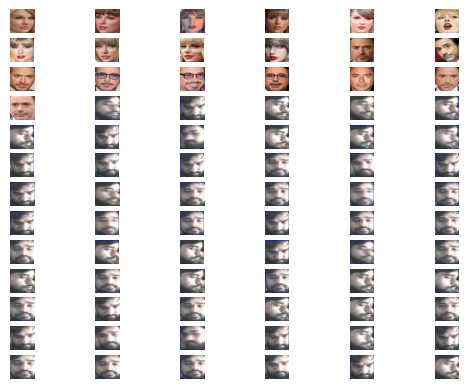

In [5]:
face_loading.plot_image()

In [6]:
embedder = FaceNet()

def get_embedding(img):
    face_img = img.astype(np.float32) # 3d (160,160,3)
    face_img = np.expand_dims(face_img,axis=0) # 4D (None,160,160,3)
    yhat = embedder.embeddings(face_img)
    return yhat

EMBEDDING_X  = []
for img in X:
    EMBEDDING_X.append(get_embedding(img))
EMBEDDING_X = np.asarray(EMBEDDING_X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━

In [7]:
np.savez_compressed("face_net_embedding",EMBEDDING_X)

<br>

# `preparation for ml SVM:`

<br>

In [8]:
Y # we need to convert this into number: we will use label encoding: cause here we use uqinue name of the folder: 

array(['taylor_swift', 'taylor_swift', 'taylor_swift', 'taylor_swift',
       'taylor_swift', 'taylor_swift', 'taylor_swift', 'taylor_swift',
       'taylor_swift', 'taylor_swift', 'robert_downey', 'robert_downey',
       'robert_downey', 'robert_downey', 'robert_downey', 'robert_downey',
       'robert_downey', 'robert_downey', 'robert_downey', 'yasin',
       'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin',
       'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin',
       'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin',
       'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin',
       'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin',
       'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin',
       'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin',
       'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin', 'yasin',
       'yasin', 'yasin', 'yasin'], dtype='<U13')

In [9]:
labelEncoder = LabelEncoder()
Y = labelEncoder.fit_transform(Y)
Y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [10]:
X_train,X_test,y_train,y_test = train_test_split(EMBEDDING_X,Y,test_size=0.2,random_state=17,shuffle=True)
print("X_train shpae : {}".format(X_train.shape))
print("y_train shpae : {}".format(y_train.shape))
print("X_test shpae : {}".format(X_test.shape))
print("y_test shpae : {}".format(y_test.shape))

X_train shpae : (63, 1, 512)
y_train shpae : (63,)
X_test shpae : (16, 1, 512)
y_test shpae : (16,)


In [11]:
X_train = X_train.reshape(63,512)
X_test = X_test.reshape(16,512)

In [12]:
model = SVC(kernel="linear",probability=True)
model.fit(X_train,y_train)

SVC(kernel='linear', probability=True)

In [13]:
y_pred = model.predict(X_test)
accuracy_score(y_pred=y_pred,y_true=y_test)*100

100.0

<br>

# `test a person:`

<br>

In [14]:
detector = MTCNN()
embedder = FaceNet()
test_img = cv.imread("train_data/robert_downey/8.jpg")
test_img = cv.cvtColor(test_img,cv.COLOR_BGR2RGB)
x,y,width,height = detector.detect_faces(test_img)[0]['box']
test_img = test_img[y:y+height ,x:x+width]
test_img = cv.resize(test_img,(160,160))
embd_vec = embedder.embeddings([test_img])
y_pred = model.predict(embd_vec)
labelEncoder.inverse_transform(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array(['robert_downey'], dtype='<U13')

In [15]:
test_img = cv.imread("train_data/taylor_swift/6.jpg")
test_img = cv.cvtColor(test_img,cv.COLOR_BGR2RGB)
x,y,width,height = detector.detect_faces(test_img)[0]['box']
test_img = test_img[y:y+height ,x:x+width]
test_img = cv.resize(test_img,(160,160))
embd_vec = embedder.embeddings([test_img])
y_pred = model.predict(embd_vec)
labelEncoder.inverse_transform(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


array(['taylor_swift'], dtype='<U13')

In [16]:

# save the svm model with pickle

with open("svm_face_verification_model.pkl",'wb') as f:
    pickle.dump(model,f)


<br>
<br>

---

# `Perform real Time faceRecognition: `

---

<br>
<br>

# connect with arudino: 

In [17]:
faces_embeddings = np.load("face_net_embedding.npz")
faces_embeddings

NpzFile 'face_net_embedding.npz' with keys: arr_0

In [18]:
import time
from serial import Serial, SerialException

# Initialize face recognition components
facenet = FaceNet()
faces_embeddings = np.load("face_net_embedding.npz")
haarcascade = cv.CascadeClassifier("haarcascade_frontalface_default.xml")
model = pickle.load(open("svm_face_verification_model.pkl", 'rb'))

UNKNOWN_THRESHOLD = 0.92
cap = cv.VideoCapture(0)


# --------------------------- arduino connection start -----------------------------------------
# Set up serial communication
arduino_port = '/dev/ttyACM0'
arduino = None

try:
    arduino = Serial(arduino_port, 9600)
    time.sleep(2)  # Give time for the connection to establish
    print("Arduino connected successfully")
except SerialException as e:
    print(f"Error connecting to Arduino: {e}")
    exit(1)
# --------------------------- arduino connection end -----------------------------------------





# Variables for timing
last_detection_time = 0
detection_duration = 30  

while cap.isOpened():
    current_time = time.time()
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break

    frame = cv.flip(frame, 1)
    rgb_img = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    gray_img = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    faces = haarcascade.detectMultiScale(gray_img, 1.3, 5)

    for x, y, w, h in faces:
            img = rgb_img[y:y+h, x:x+w]
            img = cv.resize(img, (160, 160))
            img = np.expand_dims(img, axis=0)
            ypred = facenet.embeddings(img)

            proba = model.predict_proba(ypred)
            max_proba_index = np.argmax(proba)
            confidence = proba[0][max_proba_index]
            face_name = model.classes_[max_proba_index]

            if confidence > UNKNOWN_THRESHOLD:
                final_name = labelEncoder.inverse_transform([face_name])[0]
                cv.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 255), 2)
                cv.putText(frame, str(final_name), (x, y-10), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3, cv.LINE_AA)

                if current_time - last_detection_time < detection_duration:
                    procecssing_name = f"Processing for detecting {final_name}"
                    cv.putText(frame, procecssing_name, (50, 50), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3, cv.LINE_AA)
                
                # Skip sending command to Arduino during processing period
                if current_time - last_detection_time >= detection_duration:

                    # --------------------------send info to the arudino --------------
                    arduino.write(f"OPEN {final_name}\n".encode())
                    print(f"Command sent to Arduino: OPEN {final_name}")
                    last_detection_time = current_time  
                    
            else:
                cv.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 255), 2)
                cv.putText(frame, "Unknown Person", (x, y-10), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3, cv.LINE_AA)

    cv.imshow("Face Recognition:", frame)
    if cv.waitKey(1) & 0xff == ord('q'):
        break

cap.release()
cv.destroyAllWindows()

# Close the Arduino connection when done
if arduino is not None:
    arduino.close()  


Arduino connected successfully


qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/hadi/Arduino/venv/lib/python3.12/site-packages/cv2/qt/plugins"


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━